### 2.1 CNN Models - Model Training and Development

A multilabel classifier was developed on the entire dataset of 70,000 images (61,370 as traing and 8,630 as validation). Training set was oversampled on cored plaques and CAAs by duplicating the raw images, which resulted in a total of 155,239 images.

#### Architercture of the Convolutional neural network: 
Convolutional layers contained 6 Conv layers (3x3 kernal size, 1 stride, 1 padding, 0.2 dropout) each was followed by a max pooling layer (2x2 kernal size, 2 stride). 
Fully connected layers had 2 hidden layers (512 and 100 neurons, 0.5 dropout), the output layer had three neurons with Sigmoid activation function.

Rectified Linear Unit (ReLU) was used as non-linear activation function for every layer except the output layer.

#### Training: 
The CNN model was trained in the open-source package PyTorch on four NVIDIA GTX 1080 or Titan X graphics processing units (GPUs) using the Adam optimizer with a multi-label soft margin loss function with weight decay (L2 penalty, 0.008). Training proceeded with mini-batches of 64 images with real-time data augmentation including random flips, rotations, zoom, shear, and color jitter.  


The network obtained 0.842, 0.983 and 0.810 AUC-PRC on validation set for cored plaque, diffuse plaque and cerebral amyloid angiopathy (CAA) respectively.

In [4]:
import time, os

import torch
torch.manual_seed(123456789)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [5]:
csv_path = {
    'train': 'data/CSVs/train.csv',
    'dev': 'data/CSVs/dev.csv',
}

DATA_DIR = 'data/seg/size_filtered/blobs/'
NEGATIVE_DIR = 'data/seg/negatives/'
SAVE_DIR = 'models/'

image_classes = ['cored','diffuse','CAA']

In [6]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [7]:
batch_size = 64
num_workers = 16

norm = np.load('utils/normalization.npy').item()

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class MultilabelDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = pd.read_csv(csv_path)
        self.img_path = img_path
        self.transform = transform
        c=torch.Tensor(self.data_info.loc[:,'cored'])
        d=torch.Tensor(self.data_info.loc[:,'diffuse'])
        a=torch.Tensor(self.data_info.loc[:,'CAA'])
        c=c.view(c.shape[0],1)
        d=d.view(d.shape[0],1)
        a=a.view(a.shape[0],1)
        self.raw_labels = torch.cat([c,d,a], dim=1)
        self.labels = (torch.cat([c,d,a], dim=1)>0.99).type(torch.FloatTensor)

    def __getitem__(self, index):
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.labels[index]
        raw_label = self.raw_labels[index]
        # Get image name from the pandas df
        single_image_name = str(self.data_info.loc[index,'imagename'])
        # Open image
        try:
            img_as_img = Image.open(self.img_path + single_image_name)
        except:
            img_as_img = Image.open(NEGATIVE_DIR + single_image_name)
        # Transform image to tensor
        if self.transform is not None:
            img_as_img = self.transform(img_as_img)
        # Return image and the label
        return (img_as_img, single_image_label, raw_label, single_image_name)

    def __len__(self):
        return len(self.data_info.index)

In [8]:
def imshow(inp, norm, title=None):
    """Imshow for Tensor."""
    try:
        inp = inp.numpy().transpose((1, 2, 0))
    except:
        inp = inp.transpose((1, 2, 0))
    mean = norm['mean']
    std = norm['std']
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.subplots()
    ax.imshow(inp)
    
    if title is not None:
        ax.set_title(title)
    plt.pause(0.001)

In [9]:
def plot_loss(model):
    fig = plt.figure()
    fig.subplots_adjust(left=2, right = 3, wspace=0.3, bottom = 2, top = 3)
    ax = plt.axes()

    ax.plot(model.train_loss_curve, label='train')
    ax.plot(model.dev_loss_curve, label='dev')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, gpu_id=None):
    since = time.time()

    best_loss = 10000.0
    best_model = copy.deepcopy(model)

    for epoch in range(num_epochs):
        epoch_time = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  
            else:
                model.train(False)  

            running_loss = 0.0
            running_corrects = torch.zeros(len(image_classes))

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels, raw_labels, names = data
                # wrap them in Variable
                if use_gpu:
                    if phase == 'train':
                        inputs = Variable(inputs.cuda(), requires_grad=True)
                    else:
                        inputs = Variable(inputs.cuda(), volatile=True)
                    labels = Variable(labels.cuda(), volatile=True)
                else:
                    if phase == 'train':
                        inputs =  Variable(inputs, requires_grad=True)
                    else:
                        inputs =  Variable(inputs, volatile=True)
                    labels = Variable(labels, volatile=True)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                outputs = model(inputs)
                if use_gpu:
                    predictions = (F.sigmoid(outputs)>0.5).type(torch.cuda.FloatTensor)
                else:
                    predictions = (F.sigmoid(outputs)>0.5).type(torch.FloatTensor)

                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(predictions==labels, 0).data.type(torch.FloatTensor)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                model.module.train_loss_curve.append(epoch_loss)
            else:
                model.module.dev_loss_curve.append(epoch_loss)

            if phase == 'dev' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model)
                print('best loss: ', epoch_loss)

            print('{} Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                phase, epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

        epoch_end = time.time() - epoch_time
        print('train, Epoch time {:.0f}m {:.0f}s'.format(
                epoch_end // 60, epoch_end % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return best_model

In [11]:
def dev_model(model, criterion, phase='dev'):
    phase = phase
    since = time.time()
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
              for x in [phase]}

    model.train(False) 

    running_loss = 0.0
    running_corrects = torch.zeros(len(image_classes))
    running_preds = torch.Tensor(0)          # confidence score
    running_predictions = torch.Tensor(0)    # classification prediction
    running_labels = torch.Tensor(0)
    running_raw_labels = torch.Tensor(0)

    # Iterate over data.
    for data in dataloaders[phase]:
        # get the inputs
        inputs, labels, raw_labels, names = data
        running_labels = torch.cat([running_labels, labels])
        running_raw_labels = torch.cat([running_raw_labels, raw_labels])

        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        preds = F.sigmoid(outputs) #posibility for each class
        if use_gpu:
            predictions = (preds>0.5).type(torch.cuda.FloatTensor)
        else:
            predictions = (preds>0.5).type(torch.FloatTensor)
        
        loss = criterion(outputs, labels)

        preds = preds.data.cpu()
        predictions = predictions.data.cpu()
        labels = labels.data.cpu()

        # statistics
        running_loss += loss.data[0]
        running_corrects += torch.sum(predictions==labels, 0).type(torch.FloatTensor)
        running_preds = torch.cat([running_preds, preds])
        running_predictions = torch.cat([running_predictions, predictions])


    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]

    print('{} Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                phase, epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

    print()

    time_elapsed = time.time() - since
    print('Prediction complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_acc, running_preds, running_predictions, running_labels

In [12]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
        self.drop = 0.2
     
        self.features = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 128, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(128, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 512, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),)
        
        self.classifier = nn.Sequential(nn.Linear(512 * 4 * 4, fc_nodes),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(fc_nodes, 100),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(100, num_classes))
        
        self.train_loss_curve = []
        self.dev_loss_curve = []

    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
        transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
        transforms.ToTensor(),
        transforms.Normalize(norm['mean'], norm['std'])
    ]),
    'dev': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(norm['mean'], norm['std'])
    ]),
}

image_datasets = {x: MultilabelDataset(csv_path[x], DATA_DIR, data_transforms[x])
                  for x in ['train', 'dev']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
                  for x in ['dev', 'train']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev']}

use_gpu = torch.cuda.is_available()

dataset_sizes

{'train': 155239, 'dev': 8630}

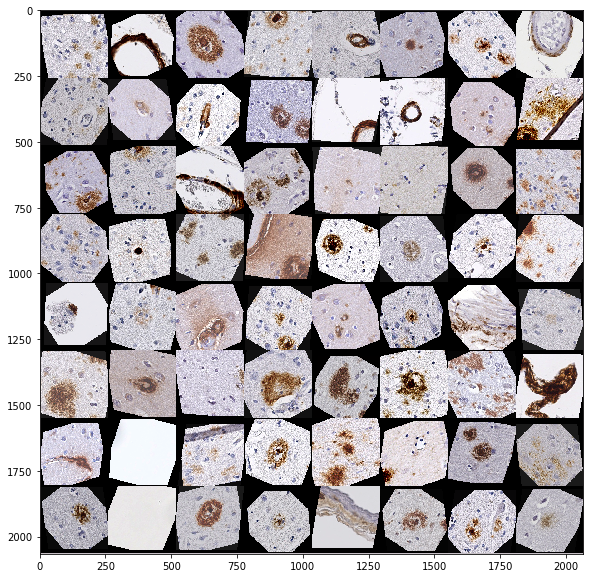

In [10]:
# Get a batch of training data
inputs, labels, raw_labels, names = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, norm)

In [20]:
weight = torch.FloatTensor([1,1,1])
model = Net()

if use_gpu:
    print('gpu')
    weight = weight.cuda()
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
    model = model.cuda()
    
criterion = nn.MultiLabelSoftMarginLoss(weight=weight, size_average=False)
optimizer = optim.Adam(model.parameters(), lr=0.00008, weight_decay=0.008)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.4)

gpu


In [21]:
best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=60)

Epoch 0/59
----------
train Loss: 1.3421
 Cored: 0.7985 Diffuse: 0.6931 CAA: 0.8632
best loss:  0.9746799760732286
dev Loss: 0.9747
 Cored: 0.7915 Diffuse: 0.8268 CAA: 0.9436
train, Epoch time 5m 38s

Epoch 1/59
----------
train Loss: 0.9141
 Cored: 0.8928 Diffuse: 0.7988 CAA: 0.9337
best loss:  0.7279303094326828
dev Loss: 0.7279
 Cored: 0.8547 Diffuse: 0.8839 CAA: 0.9662
train, Epoch time 5m 37s

Epoch 2/59
----------
train Loss: 0.7781
 Cored: 0.9175 Diffuse: 0.8252 CAA: 0.9513
best loss:  0.5194746894880629
dev Loss: 0.5195
 Cored: 0.9009 Diffuse: 0.8944 CAA: 0.9802
train, Epoch time 5m 45s

Epoch 3/59
----------
train Loss: 0.7034
 Cored: 0.9290 Diffuse: 0.8400 CAA: 0.9589
best loss:  0.4608364934026159
dev Loss: 0.4608
 Cored: 0.9177 Diffuse: 0.9074 CAA: 0.9809
train, Epoch time 5m 39s

Epoch 4/59
----------
train Loss: 0.6544
 Cored: 0.9344 Diffuse: 0.8499 CAA: 0.9640
dev Loss: 0.5009
 Cored: 0.8998 Diffuse: 0.9045 CAA: 0.9846
train, Epoch time 5m 40s

Epoch 5/59
----------
trai

train Loss: 0.3930
 Cored: 0.9608 Diffuse: 0.9037 CAA: 0.9854
dev Loss: 0.3934
 Cored: 0.9280 Diffuse: 0.9240 CAA: 0.9915
train, Epoch time 5m 44s

Epoch 48/59
----------
train Loss: 0.3895
 Cored: 0.9616 Diffuse: 0.9045 CAA: 0.9851
dev Loss: 0.4044
 Cored: 0.9269 Diffuse: 0.9228 CAA: 0.9915
train, Epoch time 5m 37s

Epoch 49/59
----------
train Loss: 0.3897
 Cored: 0.9609 Diffuse: 0.9046 CAA: 0.9854
dev Loss: 0.4040
 Cored: 0.9254 Diffuse: 0.9243 CAA: 0.9914
train, Epoch time 5m 44s

Epoch 50/59
----------
train Loss: 0.3865
 Cored: 0.9616 Diffuse: 0.9052 CAA: 0.9858
dev Loss: 0.3974
 Cored: 0.9295 Diffuse: 0.9238 CAA: 0.9914
train, Epoch time 5m 39s

Epoch 51/59
----------
train Loss: 0.3873
 Cored: 0.9619 Diffuse: 0.9055 CAA: 0.9853
dev Loss: 0.4065
 Cored: 0.9262 Diffuse: 0.9234 CAA: 0.9917
train, Epoch time 5m 36s

Epoch 52/59
----------
train Loss: 0.3855
 Cored: 0.9620 Diffuse: 0.9067 CAA: 0.9857
dev Loss: 0.4067
 Cored: 0.9260 Diffuse: 0.9228 CAA: 0.9918
train, Epoch time 5m 43

In [22]:
torch.save(best_model, SAVE_DIR+'CNN_model_parameters.pkl')

/srv/home/ztang/miniconda3/envs/pytorch/lib/python3.5/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


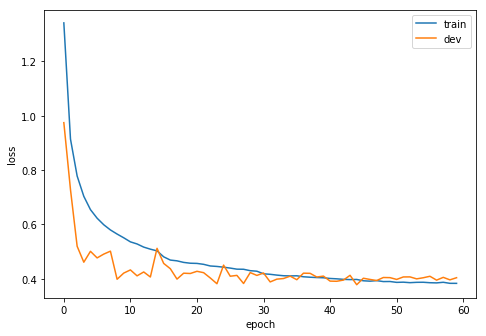

In [24]:
plot_loss(model.module)